In [6]:
import os
import numpy as np
import sys
import h5py
import matplotlib.pyplot as pl
import lightcone_LAEinterface_decreasingz_xlos as lc
import matplotlib as mpl
import compute_ps_updated 
import angular_correlation_function as acf
from astropy.cosmology import z_at_value
from astropy.cosmology import WMAP9 as cosmo
import time
import xi_2D
import LAE_Cluster as LAEC
cmap2 = mpl.colors.ListedColormap(['k', 'yellow'])
cmap3 = mpl.colors.ListedColormap(['k', 'white'])
pl.rcParams["font.family"] = "Times New Roman"
pl.rcParams['ytick.labelsize']=24
pl.rcParams['xtick.labelsize']=24
%load_ext autoreload
%autoreload 2
%matplotlib inline
start = 0.0
stop = 1
number_of_lines = 12
cm_subsection = np.linspace(start, stop, number_of_lines) 
cmap = pl.cm.Paired
cmap = cmap.reversed(pl.cm.Paired)
colors = [ cmap(x) for x in cm_subsection ]

path = '/users/michael/Research/PowerSpectrumNotebook/Boxes/'
def find_foldername(boxes_path , redshift, OUTPUT_NUMBER,  mode = 'some type'):
    #call(["echo looking for a " + str(mode) + " box at redshift " + str(redshift) ], shell = False )
    filename_list = open(boxes_path +'/filename_list_'+ str(mode) +'_' + str(OUTPUT_NUMBER) , 'w')
    call(["ls " + boxes_path + "*" + str(OUTPUT_NUMBER)], stdout = filename_list, shell = True)
    filename_list.close()
    with open(boxes_path + '/filename_list_' + str(mode) + '_' + str(OUTPUT_NUMBER), 'r') as inF:
        for line in inF:
            if mode in line and str(float(redshift)) in line and str(OUTPUT_NUMBER) in line:
                return  line.replace("\n", '')
            
def load_binary_data(filename, dtype=np.float32): 

    f = open(filename, "rb")
    data = f.read() 
    f.close() 
    _data = np.fromstring(data, dtype) 
    if sys.byteorder == 'big':
        _data = _data.byteswap()
    return _data

def box_maker(location):
    arr = load_binary_data(str(location))
    arr.shape = (HII_DIM,HII_DIM,HII_DIM)
    return arr.reshape((HII_DIM,HII_DIM,HII_DIM), order = 'F')

#new way of loading stuff
#name = 'xH_nohalos_z009.00_nf0.753192_Fstar0.0500_starPL0.5000_Fesc0.1000_escPL-0.5000_Mturn5.00e+08_HIIfilter1_RHIImax30_150_225Mpc_1337'
#data1 = np.fromfile(name ,dtype=np.float32)
#xH_data = data1.reshape((DIM,DIM,DIM))




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
#Constants for the script
slabs = 8
pixelsperslab = 25
Mpcperslab = 37.5
M_alpha_min = 1e10
DIM = 800
Box_length = 300
z_end = 6.0
N = 500
lya_min = 2.5e42
HII_DIM = 200
DIM = 800
T_ionized = 10**4 #K
T_neutral = 1 #K
depth_of_lightcone = 10 #this is in pixels

Msource = '5e8'
MturnxHII = Msource
M_alpha_min_label = '1e10'


In [44]:
homo_io ='/Users/michael/Research/LAE_Clustering/Simulation_Boxes/MturnHaloes5e8_zeta25_MturnxHII5e8_beta1_fullEoR_Seed200_xLos_noHalos/'
homo_oi = '/Users/michael/Research/LAE_Clustering/Simulation_Boxes/MturnHaloes5e8_zeta25_MturnxHII5e8_beta-1_fullEoR_Seed200_xLos/'
fcoll_directory = '/Users/michael/Research/LAE_Clustering/Trash/Collapsed_fraction_stuff/300Mpc_200pixels/'
density_boxes = '/Users/michael/Research/LAE_Clustering/Simulation_Boxes/MturnHaloes5e8_zeta25_MturnxHII5e8_beta1_fullEoR_Seed200_xLos/'
ionization_boxes = (homo_io, homo_oi)

betas = (1, -1)
z_starts = np.linspace(6.8, 6.6, 2)
print(z_starts)
nboxes = np.linspace(5,4, 2)
print(nboxes)
z_end = 6.0 #this is the z_end for the observer when computing the opacity



[6.8 6.6]
[5. 4.]


In [45]:
halo_directory = '/Users/michael/Research/LAE_Clustering/Simulation_Boxes/MturnHaloes5e8_zeta25_MturnxHII5e8_beta1_fullEoR_Seed200_xLos/'
#load all the halopos for all the redshifts
LAEpos_z = np.zeros((len(z_starts)), dtype = object)
for z in range(LAEpos_z.shape[0]):
    box = 'halos_z'+str(np.round(z_starts[z],1))+'0_800_300Mpc_82600201'
    LAEpos_z[z] = np.genfromtxt(halo_directory + box, dtype=None)

In [46]:
#where the collapsed_fraction boxes are located 

#save all the lightcones into an array, this needs to be an array where each element is a lightcone for a particular
#beta and z

xH_lightcone_beta_z_dictionary = np.zeros((len(z_starts), len(betas)), dtype  = object)
delta_lightcone_beta_z_dictionary = np.zeros((len(z_starts), len(betas)), dtype  = object)
fcoll_lightcone_beta_z_dictionary = np.zeros((len(z_starts), len(betas)), dtype  = object)
redshifts_lightcone_beta_z_dictionary = np.zeros((len(z_starts), len(betas)), dtype  = object)

for z in range(len(z_starts)):
    
    for b in range(len(betas)):
        
        #initialize a fresh dictionary for this realization of z_starts and betas
        lightcone_Dictionary = {}
        densitylightcone_Dictionary = {}
        redshifts_lightcone = {}
        fcoll_lightcone_Dictionary = {}
        print(nboxes[z])
        print(ionization_boxes[b])
        print(z_starts[z])
        for i in range(200):
            box_slice = HII_DIM - i -1
            lightcone_Dictionary[int(box_slice)] , lightcone_redshifts = lc.lightcone(DIM = HII_DIM, z_start = z_starts[z], z_end = z_end, N = N, nboxes = nboxes[z], box_slice = int(box_slice), directory =  ionization_boxes[b] , sharp_cutoff = 20, return_redshifts = True)
            densitylightcone_Dictionary[int(box_slice)] = lc.lightcone(DIM = HII_DIM, z_start = z_starts[z], z_end = z_end, N = N, nboxes = nboxes[z], box_slice = int(box_slice), directory = density_boxes , marker = 'updated_smoothed_deltax' , sharp_cutoff = 20)
            fcoll_lightcone_Dictionary[int(box_slice)] = lc.lightcone(DIM = HII_DIM, z_start = z_starts[z], z_end = z_end, N = N, nboxes = nboxes[z], box_slice = int(box_slice), directory = fcoll_directory , marker = 'Collapsed_Fraction_Box' , sharp_cutoff = 20)

        #save this dictionary into the array
        xH_lightcone_beta_z_dictionary[z][b] = lightcone_Dictionary
        delta_lightcone_beta_z_dictionary[z][b] = densitylightcone_Dictionary
        fcoll_lightcone_beta_z_dictionary[z][b] = fcoll_lightcone_Dictionary
        redshifts_lightcone_beta_z_dictionary[z][b] = lightcone_redshifts

        print(r'**** Done all betas for z = {} ' .format(z_starts[z]))
        

5.0
/Users/michael/Research/LAE_Clustering/Simulation_Boxes/MturnHaloes5e8_zeta25_MturnxHII5e8_beta1_fullEoR_Seed200_xLos_noHalos/
6.8
**** Done all betas for z = 6.8 
5.0
/Users/michael/Research/LAE_Clustering/Simulation_Boxes/MturnHaloes5e8_zeta25_MturnxHII5e8_beta-1_fullEoR_Seed200_xLos/
6.8
**** Done all betas for z = 6.8 
4.0
/Users/michael/Research/LAE_Clustering/Simulation_Boxes/MturnHaloes5e8_zeta25_MturnxHII5e8_beta1_fullEoR_Seed200_xLos_noHalos/
6.6
**** Done all betas for z = 6.6 
4.0
/Users/michael/Research/LAE_Clustering/Simulation_Boxes/MturnHaloes5e8_zeta25_MturnxHII5e8_beta-1_fullEoR_Seed200_xLos/
6.6
**** Done all betas for z = 6.6 


In [51]:
#bins that we will be using the for ACF
n_bins, acfbins = xi_2D.create_k_boundaries(0.008, 1.3 , mode = 'custom', bins = np.linspace(0.5, 300, 100))

#make an array to store the ACF across all z and betas
ACF_z_beta = np.zeros((len(z_starts), len(betas), n_bins ))

#same as above, for for different lyman alpha absorption model
ACF_z_beta_fcoll = np.zeros((len(z_starts), len(betas), n_bins ))

#intrinsic params are global for all of this
intrinsic_params = (1, 1e10)

#which slab will we be using for this analysis?
slab = '7'

for z in range(len(z_starts)):
    #make an object for this redshift
    BaseLAEs = LAEC.LAE_Cluster(LAEpos_z[z], HII_DIM, DIM, Box_length)
    #sort this object into 8 slabs
    BaseLAEs_slabs = BaseLAEs.sort_into_slabs(slabs = 8, pixelsperslab = pixelsperslab)
    #apply the intrinsic luminosity parameters
    LAE_wParams = BaseLAEs.apply_parameters(intrinsic_params, LAEpos = BaseLAEs_slabs[slab])
    
    for b in range(len(betas)):
        #apply this particular reionization scenario
        LAE_wParams_wEoR = BaseLAEs.apply_reionization_slabs(xH_lightcone_beta_z_dictionary[z][b], np.linspace(z_starts[z], z_end, nboxes[z]), T_neutral, T_ionized, LAEpos = LAE_wParams, lightcone_redshifts = redshifts_lightcone_beta_z_dictionary[z][b], density = delta_lightcone_beta_z_dictionary[z][b] )
        
        #same as above but for fcollapsed lyman alpha absorption model
        LAE_wParams_wEoR_fcoll = BaseLAEs.apply_reionization(xH_lightcone_beta_z_dictionary[z][b], np.linspace(z_starts[z], z_end, nboxes[z]), T_neutral, T_ionized, LAEpos = LAE_wParams, lightcone_redshifts = redshifts_lightcone_beta_z_dictionary[z][b], density = delta_lightcone_beta_z_dictionary[z][b], f_coll =  fcoll_lightcone_beta_z_dictionary[z][b])
        
        #remove the line of sight from the list so we can pass it to the ACF function
        rdy_for_ACF = BaseLAEs.remove_los_from_list(LAEpos = LAE_wParams_wEoR)
        
        #same as above but for second lya absorption model
        rdy_for_ACF_fcoll = BaseLAEs.remove_los_from_list(LAEpos = LAE_wParams_wEoR)

        #print('Before the ACF, the shapes of the list going in are ', rdy_for_acf_io.shape, rdy_for_acf_oi.shape )
        ACF, ACF_bins , binn_counter, countbox_list = xi_2D.ps_k(1.5, 20, temperature = rdy_for_ACF, mode = 'custom', bins = acfbins)
        
        #same as above but for new lya absorption model (fcoll)
        ACF_fcoll, ACF_bins_fcoll , binn_counter_fcoll, countbox_list_fcoll = xi_2D.ps_k(1.5, 20, temperature = rdy_for_ACF_fcoll, mode = 'custom', bins = acfbins)
        
        #save it into an array
        ACF_z_beta[z][b] = ACF
        
        #save fcoll model
        ACF_z_beta_fcoll[z][b] = ACF_fcoll
        
    print('**** Done redshift {}' .format(z_starts[z]))
        
    


There are 3431593 halos in this object


/Users/michael/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
/Users/michael/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.


computing temperature power spectrum
('looks like we got a list array of shape ', (53885, 2))
('Num halos in this box : ', 53885)
('n_density is ', 1.347125)
Checking that the field has been properly normalized - should be zero sum
2.5011104298755527e-12
('max of r range is :, ', 212.13203435596427)
('Runtime (s): ', 1.923774003982544)
computing temperature power spectrum
('looks like we got a list array of shape ', (53885, 2))
('Num halos in this box : ', 53885)
('n_density is ', 1.347125)
Checking that the field has been properly normalized - should be zero sum
2.5011104298755527e-12
('max of r range is :, ', 212.13203435596427)
('Runtime (s): ', 1.882223129272461)
computing temperature power spectrum
('looks like we got a list array of shape ', (23934, 2))
('Num halos in this box : ', 23934)
('n_density is ', 0.59835)
Checking that the field has been properly normalized - should be zero sum
-5.5706550483591855e-12
('max of r range is :, ', 212.13203435596427)
('Runtime (s): ', 1.810

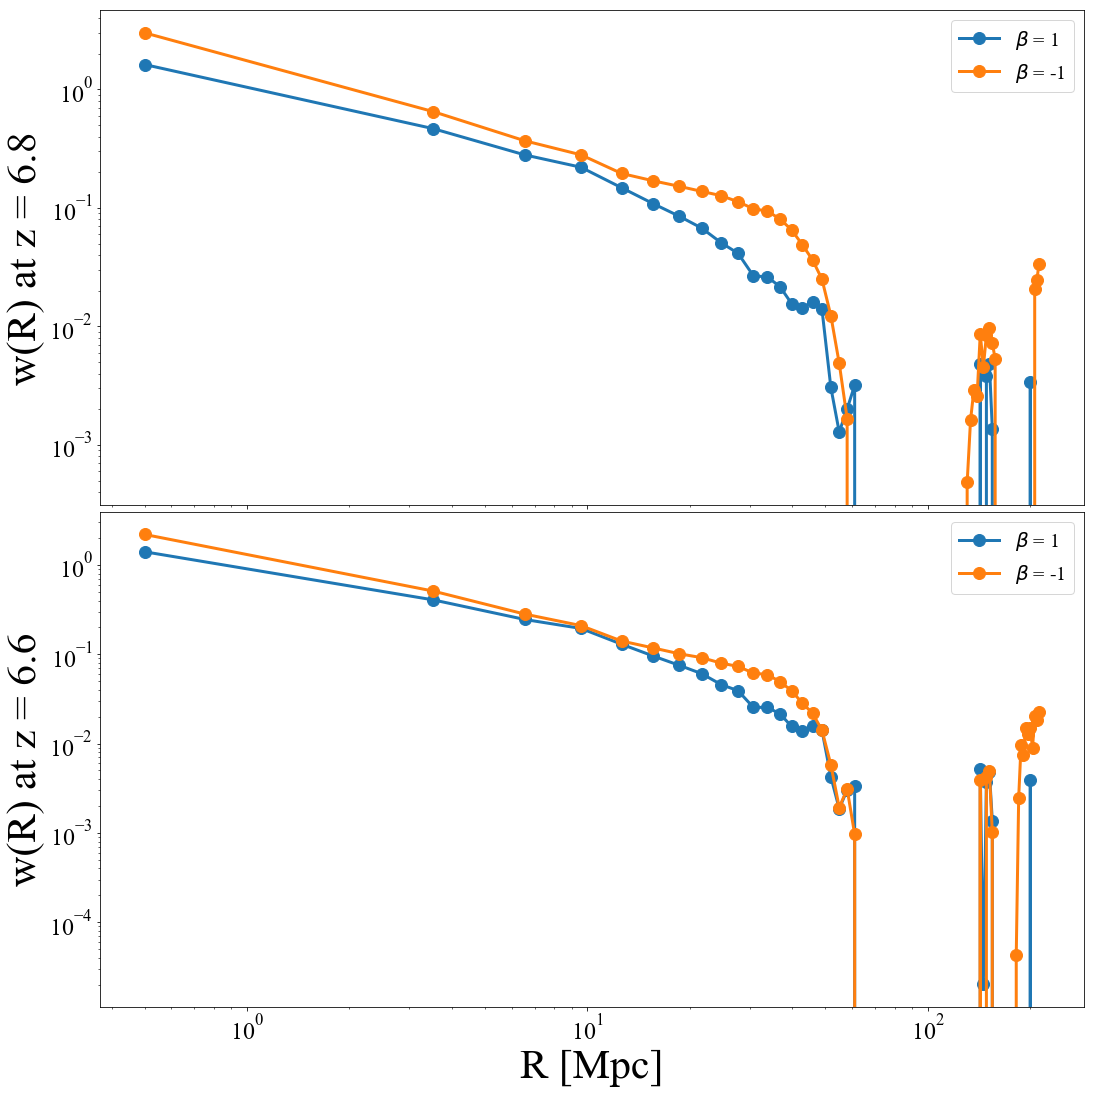

In [55]:
#maybe make this into an axarr picture?
f, axarr = pl.subplots(len(z_starts),figsize=(15, 15), sharex = True)

for z in range(len(z_starts)):
    #pl.figure(figsize = (15,8))
    for b in range(len(betas)):
        axarr[z].loglog(ACF_bins, ACF_z_beta[z,b] , marker = 'o',markersize = 12, linewidth=3. , label = r'$\beta$ = {}' .format(betas[b]))
        #axarr[z].loglog(ACF_bins, ACF_z_beta_fcoll[z,b] , marker = 'o',markersize = 12, linewidth=3. , label = r'Collapsed Model , $\beta$ = {}' .format(betas[b]))
    axarr[z].legend(prop={'size': 20})
    axarr[z].set_ylabel(r'w(R) at z = {}' .format(z_starts[z]) ,  fontsize = 42 )
    #axarr[z].set_xlim(-0.1, ACF_bins[12])
    #axarr[z].set_ylim(10**-2, 10**2)
    #axarr[int(len(z_starts)-1)].set_title('ACF at z = {}' .format(z_starts[z]), fontsize = 43)
axarr[int(len(z_starts)-1)].set_xlabel(r'R [Mpc]', fontsize = 42)
#pl.legend(prop={'size': 20})
f.tight_layout(pad = 0)
pl.tight_layout(pad = 0)
pl.show()
pl.close()

/Users/michael/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:49: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


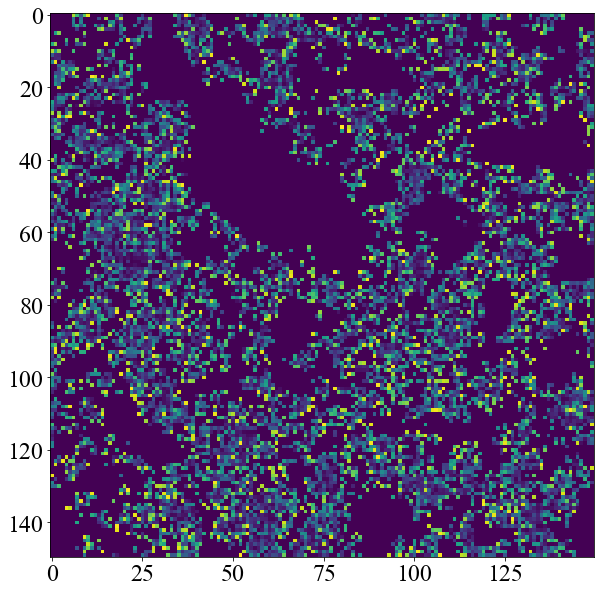

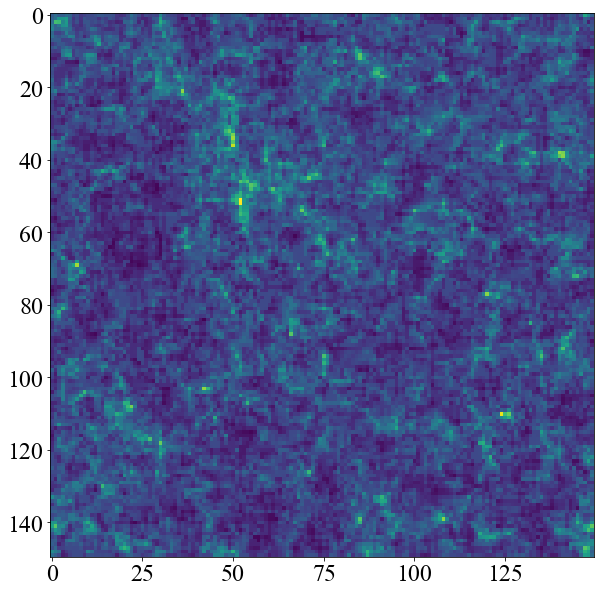

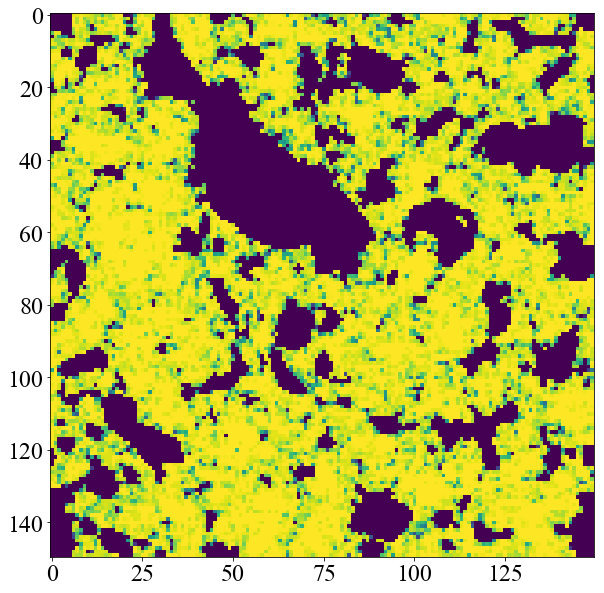

In [60]:
HII_DIM = 150
fcoll_fname = str('Collapsed_Fraction_Box_z008.60_HIIfilter1_RHIImax30_150_225Mpc_911')
xH_fname = str('xH_nohalos_z008.60_nf0.679249_Fstar0.0500_starPL0.5000_Fesc0.1000_escPL-0.5000_Mturn5.00e+08_HIIfilter1_RHIImax30_150_225Mpc_911')
density_fname = str('updated_smoothed_deltax_z008.60_150_225Mpc_911')

fcoll_box = box_maker(str(directory + fcoll_fname))
xH_box = box_maker(str(directory + xH_fname))
density_box = box_maker(directory + density_fname)

Overmean_values = np.zeros_like(fcoll_box)
for i in range(HII_DIM):
    for j in range(HII_DIM):
        for k in range(HII_DIM):
            if fcoll_box[i][j][k] < mean_fcoll:
                Overmean_values[i][j][k] = fcoll_box[i][j][k]
                


pl.figure(figsize = (10,10))
pl.imshow(Overmean_values[0])
pl.show()
pl.close()
pl.figure(figsize = (10,10))
pl.imshow(density_box[0])
pl.show()
pl.close()
pl.figure(figsize = (10,10))
pl.imshow(xH_box[0])
pl.show()
pl.close()

In [59]:
#this is to average the ACF across all slabs, it is identical in everyway to the above code with an extra loop added
#to store all the results in an array that contains all the slab dependent ACF information

#bins that we will be using the for ACF
n_bins, acfbins = xi_2D.create_k_boundaries(0.008, 1.3 , mode = 'custom', bins = np.linspace(0.5, 300, 100))

#make an array to store the ACF across all z and betas
ACF_z_beta = np.zeros((len(z_starts), len(betas), n_bins ))

#make an array to store the average of the ACF across all z and betas
ACF_z_beta_slab = np.zeros((len(z_starts), len(betas), 8,  n_bins ))


#intrinsic params are global for all of this
intrinsic_params = (1, 1e10)

for i in range(8):
    #which slab will we be using for this analysis?
    slab = str(int(7 - i))

    for z in range(len(z_starts)):
        #make an object for this redshift
        BaseLAEs = LAEC.LAE_Cluster(LAEpos_z[z], HII_DIM, DIM, Box_length)
        #sort this object into 8 slabs
        BaseLAEs_slabs = BaseLAEs.sort_into_slabs(slabs = 8, pixelsperslab = pixelsperslab)
        #apply the intrinsic luminosity parameters
        LAE_wParams = BaseLAEs.apply_parameters(intrinsic_params, LAEpos = BaseLAEs_slabs[slab])

        for b in range(len(betas)):
            #apply this particular reionization scenario
            LAE_wParams_wEoR = BaseLAEs.apply_reionization_slabs(xH_lightcone_beta_z_dictionary[z][b], np.linspace(z_starts[z], z_end, nboxes[z]), T_neutral, T_ionized, LAEpos = LAE_wParams, lightcone_redshifts = redshifts_lightcone_beta_z_dictionary[z][b], density = delta_lightcone_beta_z_dictionary[z][b] )

            #remove the line of sight from the list so we can pass it to the ACF function
            rdy_for_ACF = BaseLAEs.remove_los_from_list(LAEpos = LAE_wParams_wEoR)

            #print('Before the ACF, the shapes of the list going in are ', rdy_for_acf_io.shape, rdy_for_acf_oi.shape )
            ACF_single, ACF_bins_signle , binn_counter, countbox_list = xi_2D.ps_k(1.5, 20, temperature = rdy_for_ACF, mode = 'custom', bins = acfbins)

            #save it into an array
            #ACF_z_beta_single[z][b] = ACF_single
            
            ACF_z_beta_slab[z][b][i] = ACF_single
            
        print('**** Done redshift {}' .format(z_starts[z]))
    print('**** Done slab {}' .format(i))
    np.savez('ACF_z_beta_slab_total_6.6.npz' , ACF = ACF_z_beta_slab, bins = ACF_bins)
    #ACF_z_beta_slab[z][b][i] = ACF_z_beta[z][b]
            


        

There are 3431593 halos in this object


/Users/michael/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.


computing temperature power spectrum
('looks like we got a list array of shape ', (53885, 2))
('Num halos in this box : ', 53885)
('n_density is ', 1.347125)
Checking that the field has been properly normalized - should be zero sum
2.5011104298755527e-12
('max of r range is :, ', 212.13203435596427)
('Runtime (s): ', 1.8659660816192627)
computing temperature power spectrum
('looks like we got a list array of shape ', (23934, 2))
('Num halos in this box : ', 23934)
('n_density is ', 0.59835)
Checking that the field has been properly normalized - should be zero sum
-5.5706550483591855e-12
('max of r range is :, ', 212.13203435596427)
('Runtime (s): ', 1.6475279331207275)
**** Done redshift 6.8
There are 3896617 halos in this object
computing temperature power spectrum
('looks like we got a list array of shape ', (63574, 2))
('Num halos in this box : ', 63574)
('n_density is ', 1.58935)
Checking that the field has been properly normalized - should be zero sum
5.684341886080801e-13
('max o

('n_density is ', 1.6198)
Checking that the field has been properly normalized - should be zero sum
3.069544618483633e-12
('max of r range is :, ', 212.13203435596427)
('Runtime (s): ', 2.0578291416168213)
computing temperature power spectrum
('looks like we got a list array of shape ', (34801, 2))
('Num halos in this box : ', 34801)
('n_density is ', 0.870025)
Checking that the field has been properly normalized - should be zero sum
-6.821210263296962e-13
('max of r range is :, ', 212.13203435596427)
('Runtime (s): ', 1.7835400104522705)
**** Done redshift 6.6
**** Done slab 5
There are 3431593 halos in this object
computing temperature power spectrum
('looks like we got a list array of shape ', (50464, 2))
('Num halos in this box : ', 50464)
('n_density is ', 1.2616)
Checking that the field has been properly normalized - should be zero sum
-4.661160346586257e-12
('max of r range is :, ', 212.13203435596427)
('Runtime (s): ', 2.530993938446045)
computing temperature power spectrum
('l

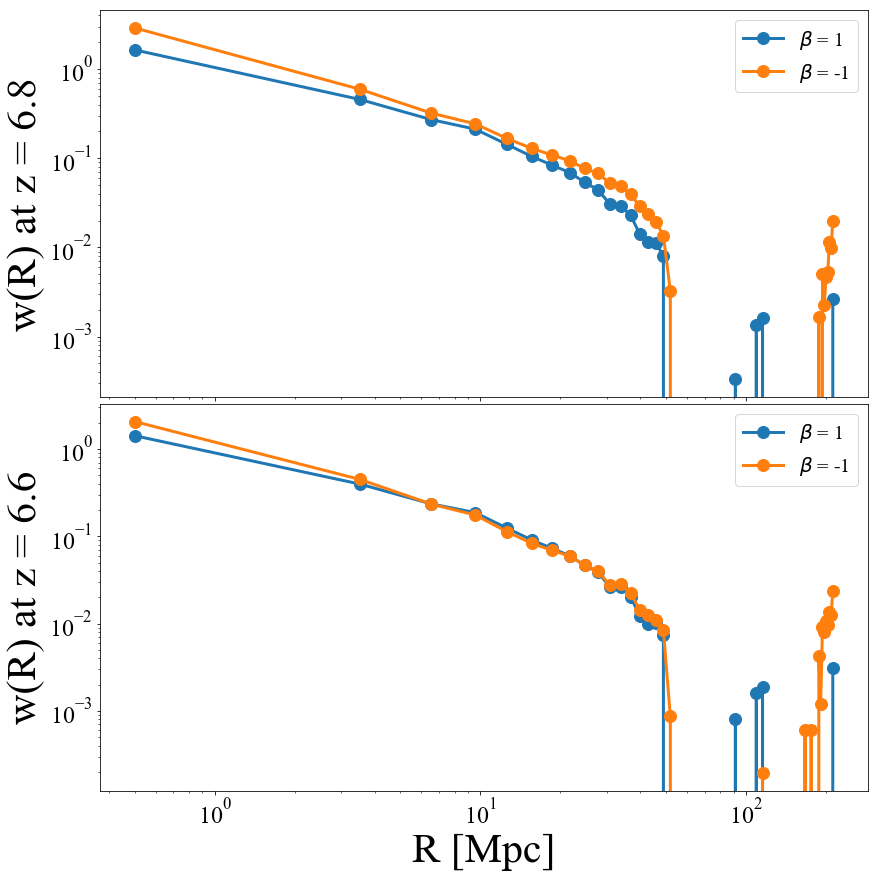

In [61]:
#maybe make this into an axarr picture?
f, axarr = pl.subplots(len(z_starts),figsize=(12, 12), sharex = True)

for z in range(len(z_starts)):
    #pl.figure(figsize = (15,8))
    for b in range(len(betas)):
        axarr[z].loglog(ACF_bins, np.true_divide(np.sum(ACF_z_beta_slab,axis = 2)[z,b], 8) , marker = 'o',markersize = 12, linewidth=3. , label = r'$\beta$ = {}' .format(betas[b]))
    axarr[z].legend(prop={'size': 20})
    axarr[z].set_ylabel(r'w(R) at z = {}' .format(z_starts[z]) ,  fontsize = 42 )
    #axarr[z].set_xlim(-0.1, ACF_bins[12])
    #axarr[z].set_ylim(10**-2, 10**2)
    #axarr[int(len(z_starts)-1)].set_title('ACF at z = {}' .format(z_starts[z]), fontsize = 43)
axarr[int(len(z_starts)-1)].set_xlabel(r'R [Mpc]', fontsize = 42)
#pl.legend(prop={'size': 20})
f.tight_layout(pad = 0)
pl.tight_layout(pad = 0)
pl.show()
pl.close()

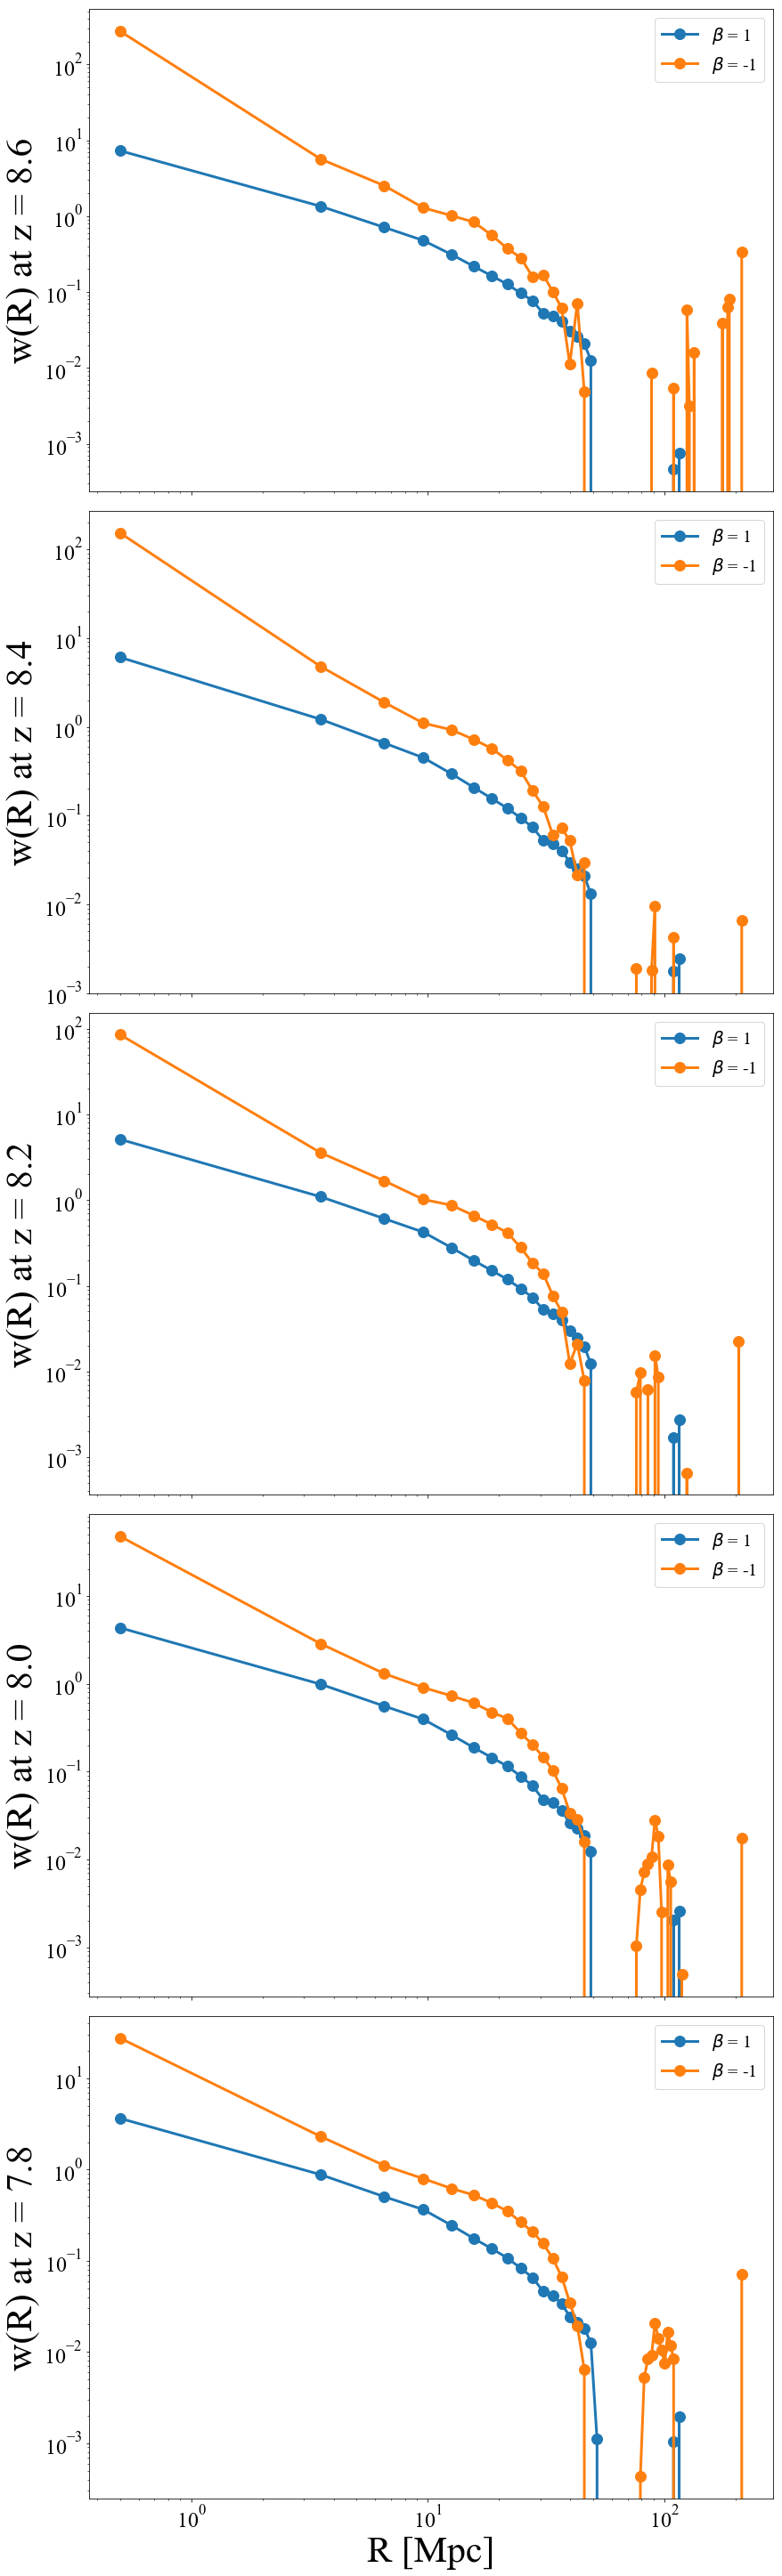

In [43]:
#maybe make this into an axarr picture?
f, axarr = pl.subplots(len(z_starts),figsize=(12, 40), sharex = True)

for z in range(len(z_starts)):
    #pl.figure(figsize = (15,8))
    for b in range(len(betas)):
        axarr[z].loglog(ACF_bins, np.true_divide(np.sum(ACF_z_beta_slab,axis = 2)[z,b], 8) , marker = 'o',markersize = 12, linewidth=3. , label = r'$\beta$ = {}' .format(betas[b]))
    axarr[z].legend(prop={'size': 20})
    axarr[z].set_ylabel(r'w(R) at z = {}' .format(z_starts[z]) ,  fontsize = 42 )
    #axarr[z].set_xlim(-0.1, ACF_bins[12])
    #axarr[z].set_ylim(10**-2, 10**2)
    #axarr[int(len(z_starts)-1)].set_title('ACF at z = {}' .format(z_starts[z]), fontsize = 43)
axarr[int(len(z_starts)-1)].set_xlabel(r'R [Mpc]', fontsize = 42)
#pl.legend(prop={'size': 20})
f.tight_layout(pad = 0)
pl.tight_layout(pad = 0)
pl.show()
pl.close()